In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df = pd.read_csv("data/credit_risk_dataset.csv")

In [3]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## Exploratory Data Analysis (EDA)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [5]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [6]:
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

*person_emp_length* and *loan_int_rate* have 895 and 3,116 null values respectively. For simplicity, we replace the null values with 0.

In [7]:
df['person_emp_length'] = df['person_emp_length'].fillna(0.0)
df['loan_int_rate'] = df['loan_int_rate'].fillna(0.0)
df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

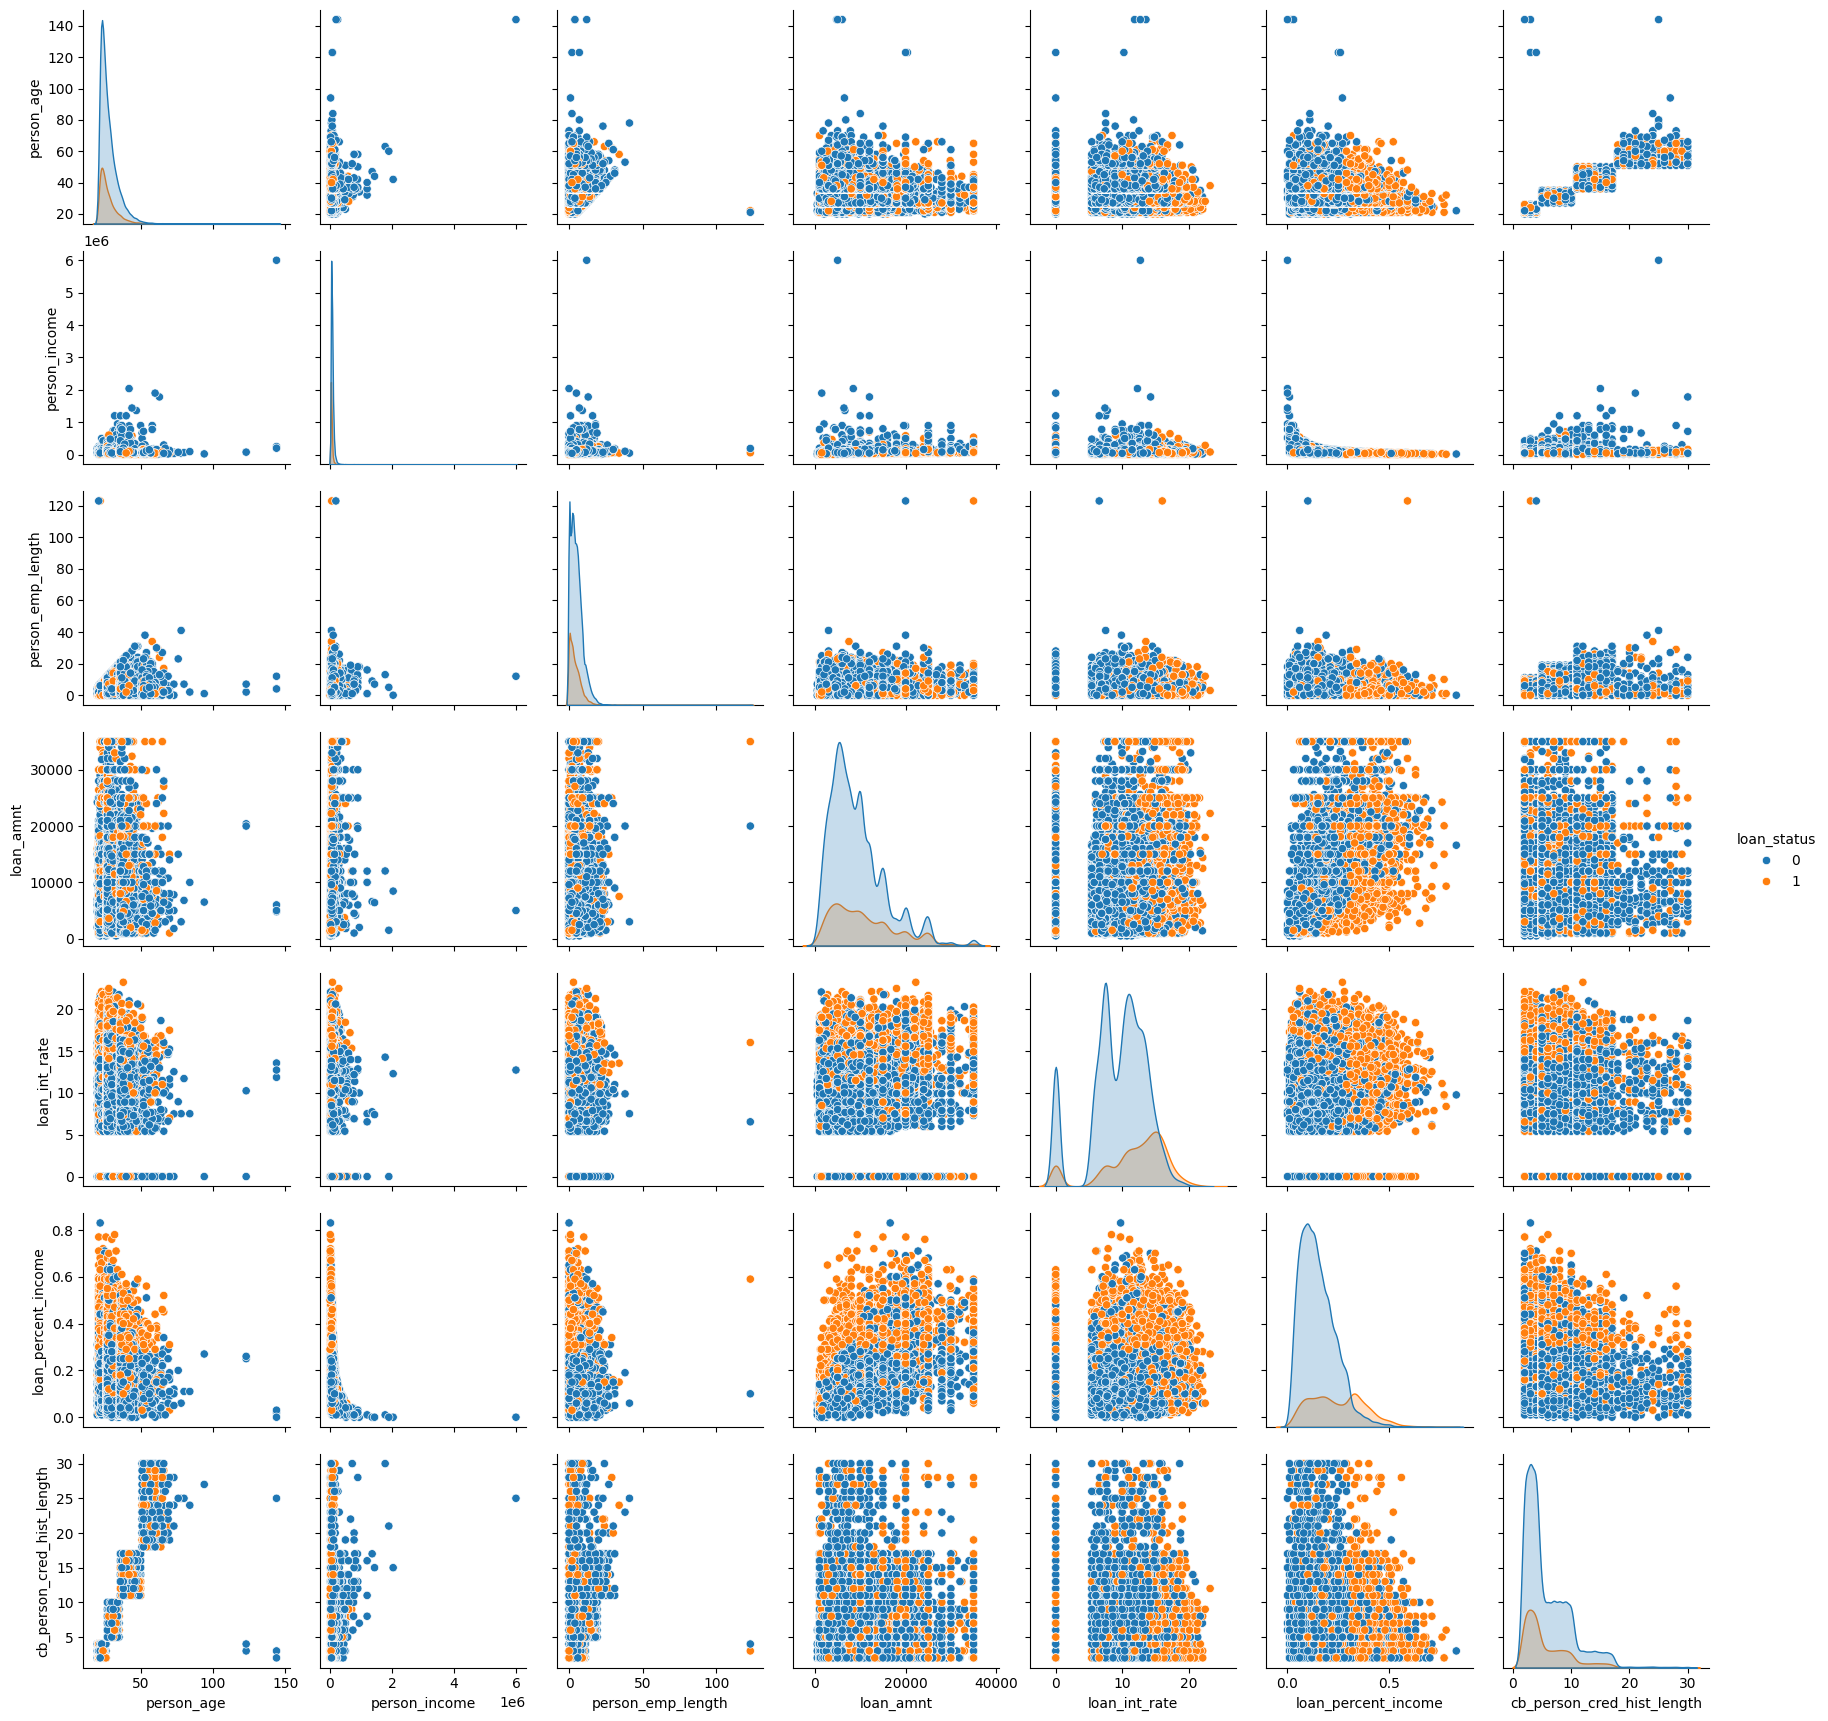

In [8]:
sns.pairplot(df, hue='loan_status')

<Axes: >

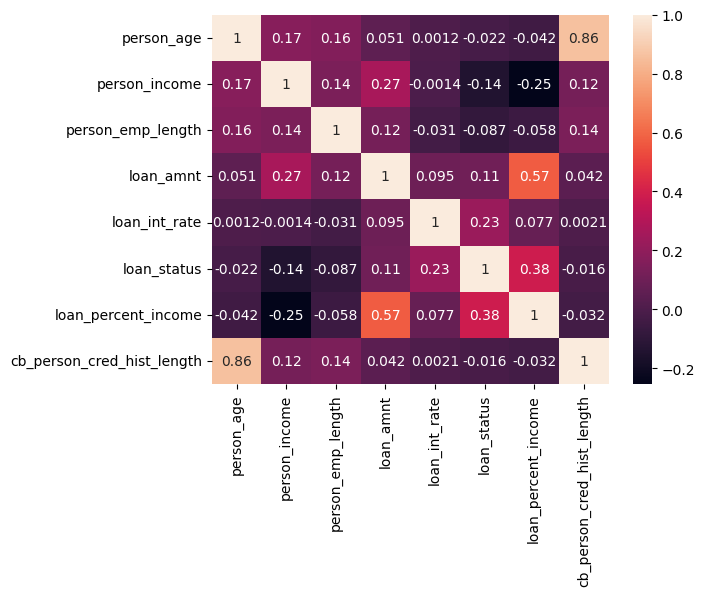

In [9]:
sns.heatmap(df.corr(numeric_only=True), annot=True)

We now look at the target variable: *loan_status*

<Axes: xlabel='loan_status', ylabel='count'>

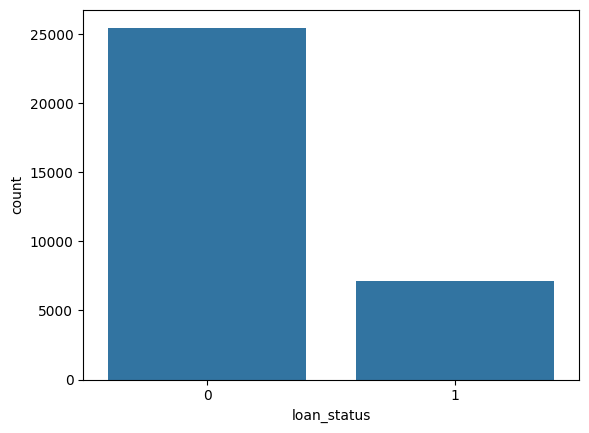

In [10]:
sns.countplot(data=df,x='loan_status')

The target variable is imbalanced, with much less instances of loan status: 1 (default).

<Axes: xlabel='loan_intent', ylabel='count'>

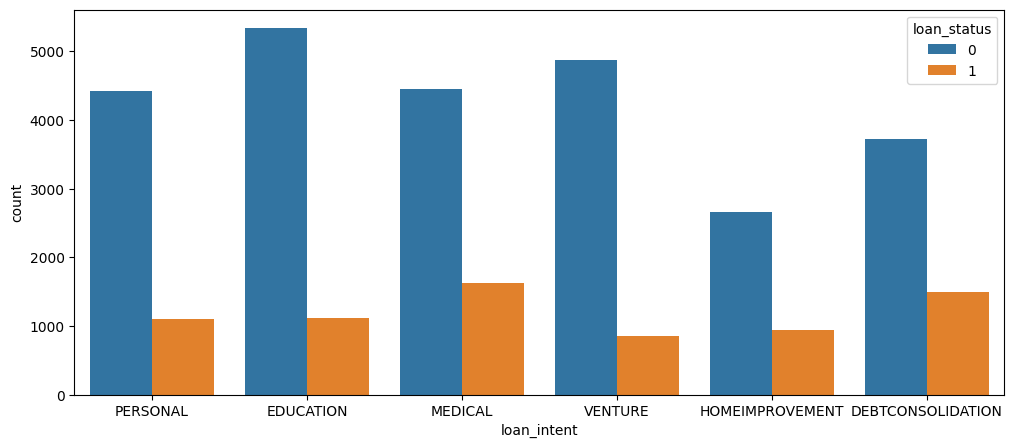

In [11]:
plt.figure(figsize=(12,5))
sns.countplot(data=df,x='loan_intent',hue='loan_status')

In [12]:
df['loan_intent'].value_counts()

loan_intent
EDUCATION            6453
MEDICAL              6071
VENTURE              5719
PERSONAL             5521
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: count, dtype: int64

We can also see the different intentions of loan, *Education* being the biggest reason for loans.

## Data Preprocessing

In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)
len(df_train), len(df_val), len(df_test)

(19548, 6516, 6517)

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
y_train = df_train.loan_status.values
y_val = df_val.loan_status.values
y_test = df_test.loan_status.values

In [16]:
del df_train['loan_status']
del df_val['loan_status']
del df_test['loan_status']

## Feature Importance Analysis

In [17]:
numerical = ['person_age', 
             'person_income', 
             'person_emp_length', 
             'loan_amnt',
             'loan_int_rate',
             'loan_percent_income',
             'cb_person_cred_hist_length']

for num in numerical:
    print(f'AUC for {num}: {round(roc_auc_score(y_train, df_train[num]),4)}')

AUC for person_age: 0.4776
AUC for person_income: 0.3121
AUC for person_emp_length: 0.4314
AUC for loan_amnt: 0.5657
AUC for loan_int_rate: 0.6839
AUC for loan_percent_income: 0.727
AUC for cb_person_cred_hist_length: 0.484


The feature with the highest AUC score is *loan_percent_income*. This is intuitive because *loan_percent_income* measures the ratio of the loan amount to the borrower's income. A lower ratio indicates that the borrower’s income is high relative to the loan amount, which reduces financial stress. On the other hand, a high *loan_percent_income* means the loan amount represents a large portion of the borrower’s income, making a borrower less likely to pay the loan, and therefore, default on a loan.

This also applies to the feature with the second-highest AUC score, *loan_int_rate*. The higher the interest rate is, more likely to default on a loan.

# Loan Default Prediction Modelling

## Logistic Regression

In [18]:
def lr_train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [19]:
def lr_predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [20]:
dv, model = lr_train(df_train, y_train)
y_pred = lr_predict(df_val, dv, model)
full_lr_auc = roc_auc_score(y_val, y_pred)
full_lr_auc

0.761721906719831

#### Logistic Regression Parameter Tuning

To find the best parameter C, we iterate over the following C values: [0.000001, 0.00001, 0.0001, 0.001, 0.01, 1].
Then, we can identify which C leads to the best mean score.

In [21]:
c_values = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 1]

In [22]:
scores = []

for c in c_values:
    dv, model = lr_train(df_train, y_train, C=c)
    y_pred = lr_predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

scores

[0.761463402585985,
 0.761728150781035,
 0.7617227392613247,
 0.7617220454767465,
 0.761721906719831,
 0.761721906719831]

It shows that different values of c does not change the accuracy score. Hence, we proceed with the full model and check on the test set.

In [23]:
y_pred = lr_predict(df_test, dv, model)
lr_auc = roc_auc_score(y_test, y_pred)
lr_auc

0.7545682654208464

## Random Forest

In [24]:
def rf_train(df_train, y_train, n_estimators=10, max_depth=10):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=1)
    rf.fit(X_train, y_train)

    return dv, rf

In [25]:
def rf_predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict(X)

    return y_pred

In [26]:
dv, model = rf_train(df_train, y_train)
y_pred = rf_predict(df_val, dv, model)
full_rf_auc = roc_auc_score(y_val, y_pred)
full_rf_auc

0.8389934129317004

#### Random Forest Parameter Tuning

First, we experiment with the n_estimators parameter with different values of from 10 to 200 with step 10.
We would like to know which value of n_estimators stops improving.

In [27]:
estimators = np.arange(10, 210, 10)

In [28]:
auc_scores = []
for n in estimators:
    dv, model = rf_train(df_train, y_train, n_estimators=n)
    y_pred = rf_predict(df_val, dv, model)
    auc_scores.append((n, round(roc_auc_score(y_val, y_pred),3)))

auc_scores

[(10, 0.839),
 (20, 0.845),
 (30, 0.845),
 (40, 0.846),
 (50, 0.843),
 (60, 0.844),
 (70, 0.845),
 (80, 0.843),
 (90, 0.845),
 (100, 0.845),
 (110, 0.845),
 (120, 0.845),
 (130, 0.846),
 (140, 0.845),
 (150, 0.846),
 (160, 0.846),
 (170, 0.846),
 (180, 0.846),
 (190, 0.845),
 (200, 0.846)]

We can see that the auc score stops improving at n_estimators = 40. However, we would like to further tune with max_depth. 
- To select the best max_depth, we try different values of max_depth: [10, 15, 20, 25].
- For each of these values, we then try different values of n_estimators from 10 till 200 (with step 10).

We will be able to identify the best max_depth and n_estimators.

In [29]:
depth = [10, 15, 20, 25]

In [31]:
auc_scores = []
best_score = 0

for d in depth:
    for n in estimators:
        dv, model = rf_train(df_train, y_train, n_estimators=n, max_depth=d)
        y_pred = rf_predict(df_val, dv, model)
        val_roc_auc = round(roc_auc_score(y_val, y_pred),3)
        auc_scores.append((d, n, val_roc_auc))

        if val_roc_auc > best_score:
            best_score = val_roc_auc
            dir = 'model'
            model_checkpoint = f'model_depth_{d}_estimator_{n}_{val_roc_auc}.bin'
            checkpoint = os.path.join(dir, model_checkpoint)
            with open(checkpoint, 'wb') as f_out:
                pickle.dump((dv, model), f_out)
            print(f"Check point saved: {checkpoint}")

Check point saved: model/model_depth_10_estimator_10_0.839.bin
Check point saved: model/model_depth_10_estimator_20_0.845.bin
Check point saved: model/model_depth_10_estimator_40_0.846.bin
Check point saved: model/model_depth_15_estimator_10_0.851.bin
Check point saved: model/model_depth_15_estimator_20_0.853.bin
Check point saved: model/model_depth_15_estimator_60_0.854.bin
Check point saved: model/model_depth_15_estimator_100_0.855.bin
Check point saved: model/model_depth_20_estimator_20_0.857.bin
Check point saved: model/model_depth_25_estimator_60_0.858.bin


In [32]:
columns = ['max_depth', 'n_estimators', 'roc_auc']
df_scores = pd.DataFrame(auc_scores, columns=columns)
df_scores.head()

,max_depth,n_estimators,roc_auc
0,10,10,0.839
1,10,20,0.845
2,10,30,0.845
3,10,40,0.846
4,10,50,0.843


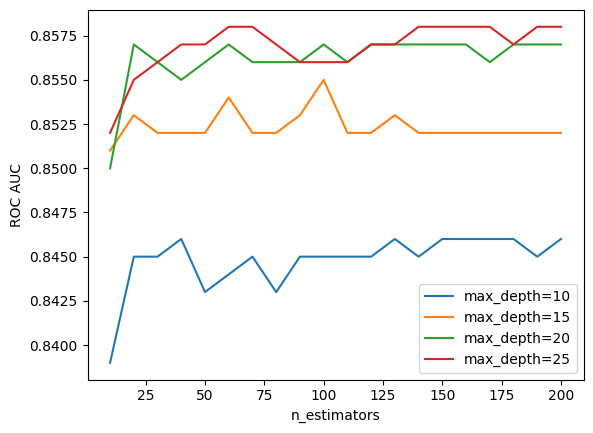

In [33]:
for d in depth:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.roc_auc, label='max_depth=%d' %d)
plt.xlabel("n_estimators")
plt.ylabel("ROC AUC")
plt.legend()

After hyper parameter tuning, the best performing model is max_depth = 25 and n_estimator = 60, and the model is saved as 'model_depth_25_estimator_60_0.858.bin'.

We now have the best performing model to use it on the test set for final evaluation.

In [34]:
dir = 'model'
model_file = os.path.join(dir, 'model_depth_25_estimator_60_0.858.bin')

with open(model_file, 'rb') as f_in:
    dv, model = pickle.load(f_in)

In [35]:
y_pred = rf_predict(df_test, dv, model)
rf_auc = roc_auc_score(y_test, y_pred)
rf_auc

0.8525084458537544

Final AUC scores: 
- Logistic Regression: 0.7545
- Random Forest: 0.8525

Therefore, we choose fine-tuned Random Forest for deployment.